# Boosting Trees
Boosting is an ensemble technique in which the predictors are not made independently, but sequentially. Gradient boosting builds an ensemble of trees one-by-one, then the predictions of the individual trees are summed:
$$ D(\mathbf{x}) = d_\text{tree 1}(\mathbf{x}) + d_\text{tree 2}(\mathbf{x}) + ... $$

The next decision tree tries to cover the discrepancy between the target function $f(\mathbf{x})$ and the current ensemble prediction by reconstructing the residual.

For example, if an ensemble has 3 trees the prediction of that ensemble is:
$$ D(\mathbf{x}) = d_\text{tree 1}(\mathbf{x}) + d_\text{tree 2}(\mathbf{x}) + d_\text{tree 3} $$

The next tree (tree 4) in the ensemble should minimize the training error of the already existing ensemble.
In the ideal case we'd be happy to have:
$$ D(\mathbf{x}) + d_\text{tree 4}(\mathbf{x}) = f(\mathbf{x}) $$

To get a bit closer to the destination, we train a tree to reconstruct the difference between the target function and the current predictions of an ensemble, which is called the residual:
$$ R(\mathbf{x}) = f(\mathbf{x}) - D(\mathbf{x}) $$

Essentially the model is training new addition, creating a preduction using all the trees and calculating the error so that the next tree can be trained using the updated error.

Below we can see the algorithm for the L2 boosting that we implemented<br>
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)


In [1]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt
import numpy as np
import math

### L2 Boost from scratch

In [2]:
class L2_Boost(BaseEstimator, ClassifierMixin):

    def __init__(self, n_trees, learning_rate):
        '''
        n_trees is the number of trees to create
        learning rate: rate of learning that will be used by model
        '''
        self.trees = []
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.f0 = None
        self.mses = []

    def fit(self, X, y):
        '''
        Fit/train model
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        '''
        self.f0 = y.mean()
        y_hat = np.ones(len(y)) * self.f0
        for i in range(self.n_trees):
            residuals = y - y_hat
            regressor = DecisionTreeRegressor(max_depth=1)
            regressor.fit(X, residuals)
            self.trees.append(regressor)
            predictions = regressor.predict(X)
            y_hat = y_hat + self.learning_rate*predictions
            self.mses.append(mean_squared_error(y, y_hat))
            
    def predict(self, X):
        '''
        Predict using fitted/trained model
        X: a matrix of data values (rows are samples, columns are attributes)
        '''
        y_hat = np.ones(X.shape[0]) * self.f0
        for tree in self.trees:
            y_hat = y_hat + self.learning_rate * tree.predict(X)
        return y_hat
    
    def get_params(self, deep=True):
        '''
        get model params
        '''
        return {
                'n_trees': self.n_trees,
                'learning_rate': self.learning_rate,
               }

    def set_params(self, **parameters):
        '''
        set model params.
        Params that can be set: n_trees, learning_rate
        '''
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

### Predict on California housing data set
We will try training a model with 1000 trees and see what happens

In [3]:
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [4]:
regressor = L2_Boost(n_trees=1000, learning_rate=0.1)
regressor.fit(X_train, y_train)

In [5]:
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

0.3396928652871119

This is a huge improvement from what we saw with the Random Forest. Boosting trees are very good at minimizing risk but also very prone to overfitting. When training with them great care must be taken to make sure that the model is not overfitting. Lets take a look at how much each new tree helps our model. (Looking at the Learning Curve like we saw before with Naive Bayes would also be a good idea) 

### Plot MSE per number of trees

Text(0.5, 1.0, 'Error as a function of number of trees')

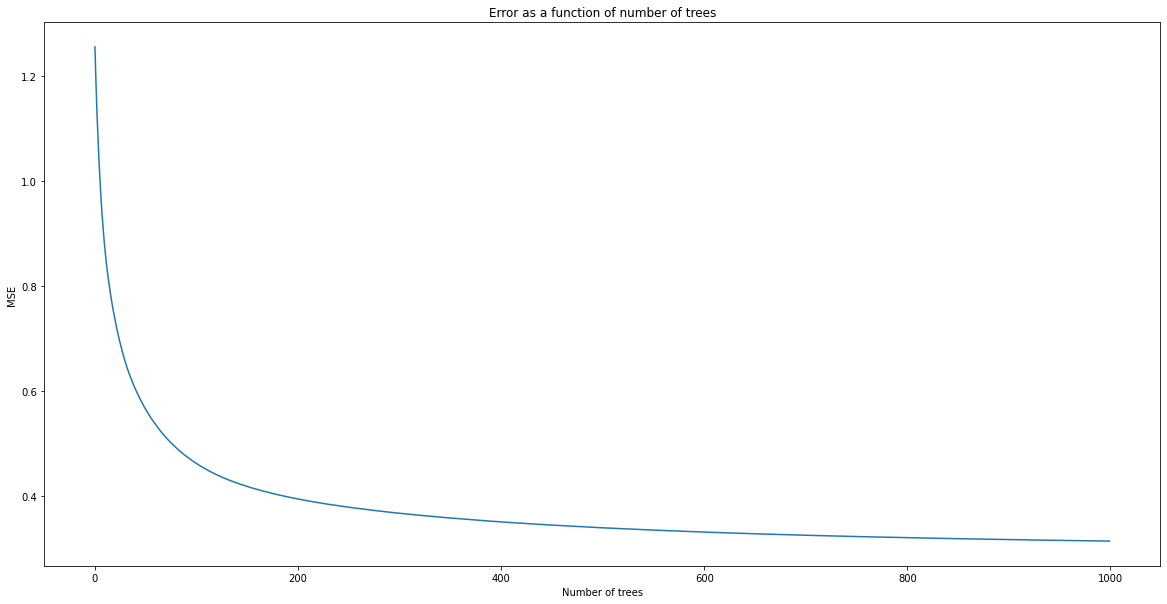

In [6]:
plt.figure(figsize=(20,10))
plt.plot(regressor.mses)
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title("Error as a function of number of trees")

Based on the above graph we can see that we could get a similar MSE with a fraction of the amount of trees. This is probably a good idea as the last 700 trees only lower the MSE a little and are probably overfitting the data.

In [7]:
regressor = L2_Boost(n_trees=300, learning_rate=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

0.39113594907461496

#### Plot Error as Trees are added 

Text(0.5, 1.0, 'Error as a function of number of trees')

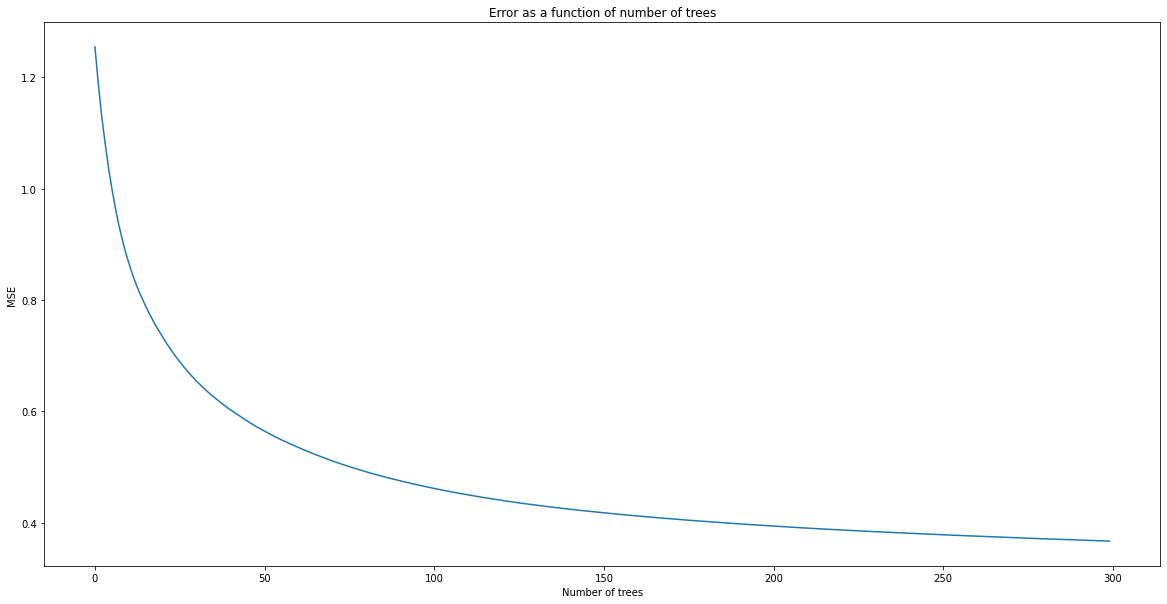

In [8]:
plt.figure(figsize=(20,10))
plt.plot(regressor.mses)
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title("Error as a function of number of trees")

That already looks much better. Based on the model and the data it is likely that even cutting down to 200 trees would be a good idea to avoid overfitting.